In [1]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model

# Sentinel 2 data

In [3]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\image\sandberg.tif') as src:
    blue = src.read(1, masked=True) #B2
    green = src.read(2, masked=True) #B3
    red = src.read(3, masked=True) #B4
    Red_Edge_1 = src.read(4, masked=True) #B5
    Red_Edge_2 = src.read(5, masked=True) #B6
    Red_Edge_3 = src.read(6, masked=True) #B7
    nir = src.read(7, masked=True) #B8
    swir_1 = src.read(8, masked=True) #B11
    swir_2 = src.read(9, masked=True) #B12

In [4]:
src=rasterio.open(r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\image\sandberg.tif',mode='r+')
srcg=gdal.Open(r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\image\sandberg.tif')
ysm=np.shape(src.read(1))[0]
xsm=np.shape(src.read(1))[1]

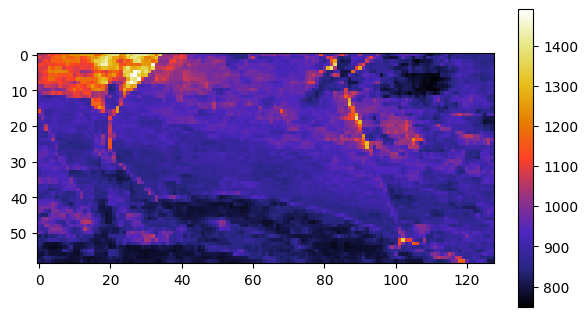

In [5]:
plt.imshow(src.read(1), cmap='CMRmap')
plt.colorbar(fraction=0.03)
plt.savefig("colbr.png")

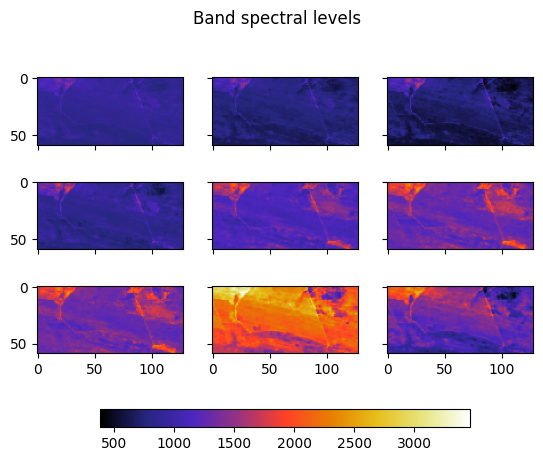

In [6]:
from matplotlib import colors

Nr = 3
Nc = 3
cmap = "CMRmap"

fig, axs = plt.subplots(Nr, Nc)
fig.suptitle('Band spectral levels')
inx=1
images = []
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        images.append(axs[i, j].imshow(src.read(inx), cmap=cmap))
        axs[i, j].label_outer()
        inx=inx+1

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=0.05)

plt.show()

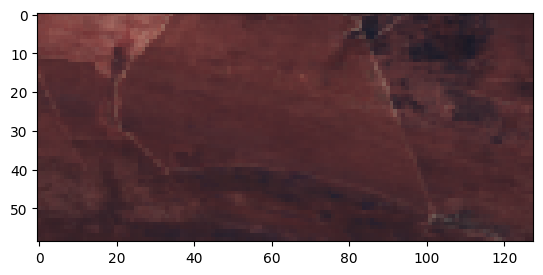

In [7]:
block2=np.zeros((ysm,xsm,12))
for j in range(1,10):
    block2[:,:,j-1]=np.minimum(src.read(j)/4096,1)
    
plt.imshow(block2[:,:,(8,2,1)])

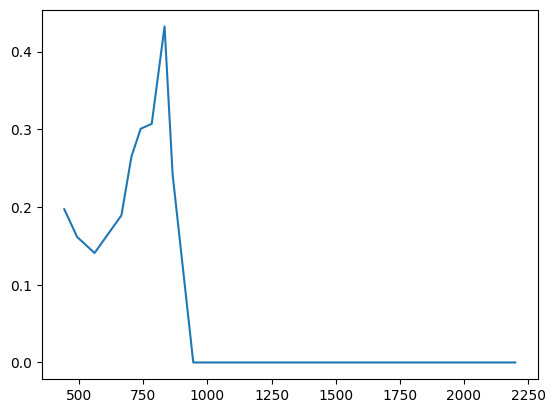

In [8]:
plt.plot(np.array((442,492,560,664.7,704,740,783,833,864.5,945,1612,2200)),block2[58,127,(0,1,2,3,4,5,6,7,8,9,10,11)])

# First a function for better control of the prosail call

In [9]:
n = 1.2 #number of observation 
car = 10 # carotenoid content of the canopy (in SPAD)
cbrown = 0.01 #Brown pigment content of the canopy (in g/cm^2)
cw = 0.015 # Equivalent water thickness of the canopy (in cm)
cm = 0.009 # Dry matter content of the canopy (in g/cm^2)
lidfa = 45 # leaf angle distribution parameter (in degrees)
hspot = 0.01 # Hotspot parameter (in cm)
tts = 30 # solar zenith angle (in degrees)
tto = 10 # sensor zenith angle (in degrees)
psi = 0 # Azimuth angle - difference between sun and sensor (in degrees)
ant = 0 #Antenna effect (in percent)
alpha = 40.0 # weighting factor for the PRI (photochemical reflectance index)
prospect_version = '5' #prospect version
typelidf = 2 # leaf type index 
lidfb = 0.0 #leaf angle distribution parameter for background (in degrees)
factor = 'DHR' # soil factor 
rsoil0 = None # initial value for the soil reflectance
rsoil = 1 # soil reflectance 
psoil = 1 #soil reflectance at the red edge position 
soil_spectrum1 = None # first soil spectrum
soil_spectrum2 = None #second soil spectrum 
  

lai_range = np.arange(0, 10, 0.5) #range of LAI values (from 0 to 10 with increaments of 0.5)
cab_range = np.arange(10, 100, 5) #range of cab values (from 10 to 100 with increaments of 5)
rho_canopy = np.zeros((360,2101)) #list to store the spectral rho_canopy values (lai_range(20) * cab_range(18) = 360)
i=0
for lai in lai_range:
    for cab in cab_range:
        rho_canopy[i,0:2101] = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, hspot, tts, tto, psi, \
                    ant=ant, alpha=alpha, prospect_version=prospect_version, typelidf=typelidf, lidfb=lidfb, \
                    factor=factor, rsoil0=rsoil0, rsoil=rsoil, psoil=psoil, \
                    soil_spectrum1=soil_spectrum1, soil_spectrum2=soil_spectrum2)
        #rho_canopy[i,:2102]=lai
        #rho_canopy[i,:2103]=cab
        i+=1
print(i,rho_canopy)

360 [[ 0.2377      0.23729999  0.2369     ...  0.44710001  0.44670001
   0.44639999]
 [ 0.2377      0.23729999  0.2369     ...  0.44710001  0.44670001
   0.44639999]
 [ 0.2377      0.23729999  0.2369     ...  0.44710001  0.44670001
   0.44639999]
 ...
 [ 0.01177935  0.01179499  0.01180603 ... -0.00100044 -0.00092852
  -0.00091887]
 [ 0.0117822   0.01179755  0.01180826 ... -0.00100044 -0.00092852
  -0.00091887]
 [ 0.01178465  0.01179969  0.01181009 ... -0.00100044 -0.00092852
  -0.00091887]]


In [10]:
#Wavelength from 300 to 2500 nm 
wl = range(400, 2500+1)

In [11]:
df = pd.DataFrame(rho_canopy, columns=list(wl))
df

,400,401,402,403,404,405,406,407,408,409,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.237700,0.237300,0.236900,0.236500,0.236000,0.235600,0.235200,0.234800,0.234400,0.234000,...,0.448200,0.44820,0.448200,0.448200,0.448200,0.447800,0.447500,0.4471,0.446700,0.446400
1,0.237700,0.237300,0.236900,0.236500,0.236000,0.235600,0.235200,0.234800,0.234400,0.234000,...,0.448200,0.44820,0.448200,0.448200,0.448200,0.447800,0.447500,0.4471,0.446700,0.446400
2,0.237700,0.237300,0.236900,0.236500,0.236000,0.235600,0.235200,0.234800,0.234400,0.234000,...,0.448200,0.44820,0.448200,0.448200,0.448200,0.447800,0.447500,0.4471,0.446700,0.446400
3,0.237700,0.237300,0.236900,0.236500,0.236000,0.235600,0.235200,0.234800,0.234400,0.234000,...,0.448200,0.44820,0.448200,0.448200,0.448200,0.447800,0.447500,0.4471,0.446700,0.446400
4,0.237700,0.237300,0.236900,0.236500,0.236000,0.235600,0.235200,0.234800,0.234400,0.234000,...,0.448200,0.44820,0.448200,0.448200,0.448200,0.447800,0.447500,0.4471,0.446700,0.446400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.011772,0.011788,0.011800,0.011818,0.011846,0.011874,0.011905,0.011939,0.011981,0.012019,...,-0.001317,-0.00124,-0.001199,-0.001137,-0.001111,-0.001089,-0.001021,-0.0010,-0.000929,-0.000919
356,0.011776,0.011792,0.011803,0.011821,0.011849,0.011877,0.011907,0.011942,0.011983,0.012021,...,-0.001317,-0.00124,-0.001199,-0.001137,-0.001111,-0.001089,-0.001021,-0.0010,-0.000929,-0.000919
357,0.011779,0.011795,0.011806,0.011824,0.011851,0.011879,0.011909,0.011943,0.011985,0.012023,...,-0.001317,-0.00124,-0.001199,-0.001137,-0.001111,-0.001089,-0.001021,-0.0010,-0.000929,-0.000919
358,0.011782,0.011798,0.011808,0.011825,0.011853,0.011880,0.011911,0.011945,0.011986,0.012024,...,-0.001317,-0.00124,-0.001199,-0.001137,-0.001111,-0.001089,-0.001021,-0.0010,-0.000929,-0.000919


### Then a function to convert the input hyperspectral data to Sentinel 2A data using a weighted mean approach

In [12]:
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"
#s2_table = pd.read_csv(filepath,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
#s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values betspectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index)ween 400 and 2500
#spectra_input_df = pd.DataFrame(data=rho_canopy[0,0:2101].T,columns=["rho"],index=s2_table_sel.index) 


In [13]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"


#### combine simulated data into sentinel 2 response

In [14]:
#simulated = Prosail2S2(filepath, rho_canopy[0,0:2101].T)#[np.array((2,3,4,5,6,7,8,11,12))]
#simulated

In [15]:
tr_rho_s = np.zeros((360, 9))
for i in range(360):
    tr_rho_s[i, :] = Prosail2S2(filepath, rho_canopy[i,0:2101].T)[np.array((2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

wl = range(400, 2500+1)
simulated = pd.DataFrame(tr_rho_s, columns = ('BAND_2', 'BAND_3', 'BAND_4', 'BAND_5', 'BAND_6', 'BAND_7', 'BAND_8', 'BAND_11', 'BAND_12'))
simulated


(360, 9)


,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_11,BAND_12
0,0.263540,0.317445,0.338128,0.358584,0.378643,0.400059,0.412764,0.509069,0.493032
1,0.263540,0.317445,0.338128,0.358584,0.378643,0.400059,0.412764,0.509069,0.493032
2,0.263540,0.317445,0.338128,0.358584,0.378643,0.400059,0.412764,0.509069,0.493032
3,0.263540,0.317445,0.338128,0.358584,0.378643,0.400059,0.412764,0.509069,0.493032
4,0.263540,0.317445,0.338128,0.358584,0.378643,0.400059,0.412764,0.509069,0.493032
...,...,...,...,...,...,...,...,...,...
355,0.002743,0.009927,0.001681,0.101070,0.191298,0.192469,0.192481,0.027465,-0.010952
356,0.003122,0.010023,0.001624,0.097978,0.191277,0.192469,0.192481,0.027465,-0.010952
357,0.003496,0.010096,0.001630,0.095055,0.191255,0.192469,0.192481,0.027465,-0.010952
358,0.003862,0.010153,0.001684,0.092288,0.191234,0.192469,0.192481,0.027465,-0.010952


# Dataframes to store values of extracted pixel

In [16]:
from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [17]:
dataframe = r'C:\Users\BSibiya\Desktop\Sandberg Fynbos Reserve\dataset.xlsx'
dataframe = pd.read_excel(dataframe)
#measured.head()

In [18]:
#Use columns names from dataframe created previously to select predictor variables for the model
X_data = df.iloc[:, 0:9].values 
y_data = df.iloc[:, 9:10].values 

In [20]:
#simulated = simulated[np.newaxis,:]

In [25]:
measured = dataframe[['BAND_2', 'BAND_3', 'BAND_4', 'BAND_5','BAND_6', 'BAND_7', 'BAND_8', 'BAND_11','BAND_12']]
measured.head()

,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_11,BAND_12
0,934,803,760,908,1140,1276,1309,2411,1486
1,948,812,758,925,1160,1291,1341,2405,1500
2,921,788,724,905,1170,1305,1337,2351,1433
3,948,805,759,919,1145,1279,1297,2428,1491
4,964,826,789,932,1160,1297,1326,2501,1568


In [ ]:
from sklearn.preprocessing import MinMaxScaler   
 

### Merge measured against Simulated

In [21]:
from sklearn import metrics

In [22]:
sum = 0
for i in range(0, 18+1):
    for j in range(0, 20+1):
        print(i*j, " ", end='')
    print()

0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
0  2  4  6  8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  
0  3  6  9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  
0  4  8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  
0  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100  
0  6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96  102  108  114  120  
0  7  14  21  28  35  42  49  56  63  70  77  84  91  98  105  112  119  126  133  140  
0  8  16  24  32  40  48  56  64  72  80  88  96  104  112  120  128  136  144  152  160  
0  9  18  27  36  45  54  63  72  81  90  99  108  117  126  135  144  153  162  171  180  
0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  
0  11  22  33  44  55  66  77  88  99  110  121  132  143  154  165  176  187  1

In [26]:
meas=np.array(measured)/np.mean(np.array(measured))*np.mean(np.array(simulated))
mse=np.zeros((40,360))
for j in np.arange(360):
    for i in np.arange(40):
    #     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
        mse[i,j]=np.sum((np.array(simulated)[j,:]-meas[i,:])**2)
ind=np.argmin(mse,axis=1)
print(ind, mse[:,ind])

[ 89  71  89  71  71  71  71  71  71  71  71  71  89  89  89  89  89  89
  89  89  89  89  89  89  89  89  89 125 107 107 107 107  89  89  89  89
  89  89  89  89] [[0.07706769 0.07715997 0.07706769 ... 0.07706769 0.07706769 0.07706769]
 [0.07547824 0.07496251 0.07547824 ... 0.07547824 0.07547824 0.07547824]
 [0.07172331 0.07309107 0.07172331 ... 0.07172331 0.07172331 0.07172331]
 ...
 [0.07699093 0.0798105  0.07699093 ... 0.07699093 0.07699093 0.07699093]
 [0.07679365 0.07949407 0.07679365 ... 0.07679365 0.07679365 0.07679365]
 [0.07853488 0.07988662 0.07853488 ... 0.07853488 0.07853488 0.07853488]]


In [27]:
meas=np.array(measured)/np.mean(np.array(measured))*np.mean(np.array(simulated))
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(simulated)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    print(ind, mses[ind])

89 0.07706768658303467
71 0.07496251127137339
89 0.07172330690992929
71 0.07748733020045756
71 0.07747475031634687
71 0.07293977055481027
71 0.07676728592774934
71 0.08106512897877294
71 0.07864563019111175
71 0.07768985408419579
71 0.07786753881902506
71 0.07927747014282362
89 0.07806209411164804
89 0.07172676924642879
89 0.06798246304222992
89 0.06963851211783276
89 0.07418843921935535
89 0.06966921378592991
89 0.0458425005508771
89 0.05982696608944008
89 0.06741245790213976
89 0.060023689773388
89 0.07149087497842264
89 0.06588023591071698
89 0.06701112969029213
89 0.06970105493293266
89 0.06998037178955374
125 0.03542225440565918
107 0.03546309168206447
107 0.023369999263968103
107 0.027008610087304926
107 0.036273847797519986
89 0.06859156910260301
89 0.07724044719537476
89 0.07225381905512135
89 0.07471763362021004
89 0.0762765851810904
89 0.0769909297094617
89 0.0767936545058969
89 0.07853488046965283


In [ ]:
np.array(simulated).shape